In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

Failed to download (trying next):
<urlopen error [WinError 10061] No connection could be made because the target machine actively refused it>



100.0%


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
<urlopen error [WinError 10061] No connection could be made because the target machine actively refused it>



100.0%


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
<urlopen error [WinError 10061] No connection could be made because the target machine actively refused it>



100.0%


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
<urlopen error [WinError 10061] No connection could be made because the target machine actively refused it>



100.0%

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



In [3]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}") # images of digits
    #             (N) Batch Size, (C)hannels, (H)eight, (W)idth
    print(f"Shape of y: {y.shape} {y.dtype}") # labels of image
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [4]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [5]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [6]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [7]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [8]:
epochs = 16
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.302683  [   64/60000]
loss: 2.295504  [ 6464/60000]
loss: 2.301701  [12864/60000]
loss: 2.289718  [19264/60000]
loss: 2.287965  [25664/60000]
loss: 2.282917  [32064/60000]
loss: 2.277411  [38464/60000]
loss: 2.274375  [44864/60000]
loss: 2.265820  [51264/60000]
loss: 2.258742  [57664/60000]
Test Error: 
 Accuracy: 43.6%, Avg loss: 2.256282 

Epoch 2
-------------------------------
loss: 2.255504  [   64/60000]
loss: 2.240200  [ 6464/60000]
loss: 2.241116  [12864/60000]
loss: 2.243434  [19264/60000]
loss: 2.222584  [25664/60000]
loss: 2.220969  [32064/60000]
loss: 2.232376  [38464/60000]
loss: 2.201157  [44864/60000]
loss: 2.209198  [51264/60000]
loss: 2.193204  [57664/60000]
Test Error: 
 Accuracy: 59.1%, Avg loss: 2.190128 

Epoch 3
-------------------------------
loss: 2.192924  [   64/60000]
loss: 2.179437  [ 6464/60000]
loss: 2.168612  [12864/60000]
loss: 2.173397  [19264/60000]
loss: 2.182642  [25664/60000]
loss: 2.171867  [32064/600

In [9]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [10]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth", weights_only=True))

<All keys matched successfully>

Test Data Len: 10000
Predicted: "6", Actual: "5"
Predicted: "6", Actual: "4"
Predicted: "3", Actual: "2"
Predicted: "3", Actual: "1"
Predicted: "2", Actual: "6"
Predicted: "4", Actual: "9"
Predicted: "2", Actual: "3"
Predicted: "2", Actual: "6"
Predicted: "7", Actual: "9"
Predicted: "7", Actual: "2"
Predicted: "9", Actual: "7"
Predicted: "5", Actual: "3"
Predicted: "4", Actual: "9"
Predicted: "1", Actual: "7"
Predicted: "9", Actual: "7"
Predicted: "8", Actual: "2"
Predicted: "4", Actual: "9"
Predicted: "3", Actual: "2"
Predicted: "1", Actual: "7"
Predicted: "4", Actual: "9"
Predicted: "3", Actual: "5"
Predicted: "8", Actual: "3"
Predicted: "5", Actual: "6"
Predicted: "7", Actual: "5"
Predicted: "7", Actual: "8"
Predicted: "8", Actual: "9"
Predicted: "9", Actual: "7"
Predicted: "5", Actual: "3"
Predicted: "6", Actual: "4"
Predicted: "9", Actual: "4"
Predicted: "0", Actual: "6"
Predicted: "3", Actual: "5"
Predicted: "5", Actual: "8"
Predicted: "4", Actual: "8"
Predicted: "3", Actual: "8"

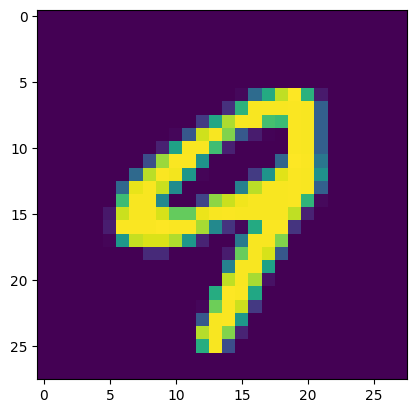

In [11]:
import matplotlib.pyplot as plt
# from random import shuffle

classes = [str(x) for x in range(10)]

model.eval()
fail = 0
print("Test Data Len: " + str(len(test_data)))

for x, y in test_data:
  with torch.no_grad():
      x = x.to(device)
      pred = model(x)
      predicted, actual = classes[pred[0].argmax(0)], classes[y]
      if(predicted != actual):
        plt.imshow(  x.detach().cpu().permute(1, 2, 0)  )
        print(f'Predicted: "{predicted}", Actual: "{actual}"')
        fail += 1

print("Tests:" + str(len(test_data) - fail) + "/" + str(len(test_data)) + " OK")